In [1]:
import numpy as np
import pandas as pd
# import spektral

In [2]:
np.random.seed(42)

In [3]:
import os 

path = '/content/drive/My Drive/IIITH/GCN_KEGG/GCN_Dataset/CSV'
os.listdir(path)

['Clinical_KICH_81_tumors.csv',
 'Clinical_KIRP_290_tumors.csv',
 'Clinical_KIRC_518_tumors.csv',
 'KICH_81_tumors_log_transformed.csv',
 'KIRP_290_tumors_log_transformed.csv',
 'KIRC_518_tumors_log_transformed.csv',
 '.DS_Store']

In [4]:
def load_dataset(path, filename, transpose=True):
    '''
        Loads the dataset and converts into its transpose with appropriate columns
    '''
    df = pd.read_csv(os.path.join(path, filename))
    df.rename(columns={"Unnamed: 0": "pid"}, inplace=True)
    if transpose:
        df = df.astype({"pid": str})
        df = df.T
        new_header = df.iloc[0] 
        df = df[1:]
        df.columns = new_header
    return df

In [5]:
df_kirc = load_dataset(path,'KIRC_518_tumors_log_transformed.csv',transpose=True)
patient_data_kirc = load_dataset(path,'Clinical_KIRC_518_tumors.csv',transpose=False)
pid_kirc_drop1 = patient_data_kirc[patient_data_kirc['ajcc_pathologic_tumor_stage']=='[Not Available]'].pid
pid_kirc_drop2 = patient_data_kirc[patient_data_kirc['ajcc_pathologic_tumor_stage']=='[Discrepancy]'].pid
patient_data_kirc.drop(patient_data_kirc[patient_data_kirc['ajcc_pathologic_tumor_stage']=='[Not Available]'].index, inplace=True )
patient_data_kirc.drop(patient_data_kirc[patient_data_kirc['ajcc_pathologic_tumor_stage']=='[Discrepancy]'].index, inplace=True )
df_kirc.drop(pid_kirc_drop1,inplace=True)
df_kirc.drop(pid_kirc_drop2,inplace=True)

y_kirc=[]
for pid in df_kirc.index:
    stage=patient_data_kirc[patient_data_kirc['pid']==pid]['ajcc_pathologic_tumor_stage']
    stage = stage.values[0]
    if stage=='Stage I':
        y_kirc.append(0)
    elif stage=='Stage II':
        y_kirc.append(0)
    elif stage=='Stage III':
        y_kirc.append(1)
    elif stage=='Stage IV':
        y_kirc.append(1)

data = df_kirc
y = y_kirc

(array([314.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 201.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

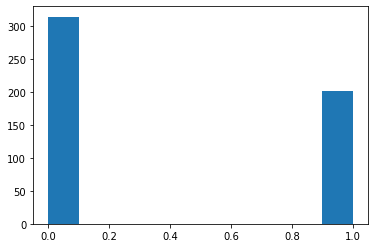

In [6]:
import matplotlib.pyplot as plt
plt.hist(y)

In [7]:
def get_features_matrix(pathway):

  genes_used = set()

  for i in range(len(pathway)):
      genes_used.add(pathway.iloc[i]['from'][4:])
      genes_used.add(pathway.iloc[i]['to'][4:])

  to_remove = []

  for gene in genes_used:
      if gene not in data.columns:
          to_remove.append(gene)

  for gene in to_remove:
    genes_used.remove(gene)

  genes_used = list(genes_used)
  genes_used.sort()

  return genes_used

In [8]:
kegg_pathways_path = '/content/drive/My Drive/IIITH/GCN_KEGG/KEGG_csv'

In [9]:
def store_pca_tsne_plots(X, y, fname):
  path_to_save = '/content/drive/My Drive/IIITH/GCN_KEGG/KIRC_Stage_TSNE_PCA_Plots'
  from sklearn.manifold import TSNE
  tsne = TSNE(n_components=2, random_state=0, perplexity=35)
  X_2d_tsne = tsne.fit_transform(X)
  from matplotlib import pyplot as plt
  plt.figure(figsize=(6, 5))
  plt.scatter(X_2d_tsne[:, 0], X_2d_tsne[:, 1], c=y)
  plt.savefig(os.path.join(path_to_save,'tsne',fname+'_tsne.png'))
  plt.close()
  from sklearn.decomposition import PCA
  pca = PCA(n_components=2, whiten=True)
  X_2d_pca = pca.fit_transform(X) 
  plt.scatter(X_2d_pca[:, 0], X_2d_pca[:, 1], c=y) 
  plt.savefig(os.path.join(path_to_save,'pca',fname+'_pca.png'))
  plt.close()
  from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
  lda = LinearDiscriminantAnalysis(n_components=2)
  X_r2 = lda.fit(X, y).transform(X)
  plt.figure(figsize=(6, 5))
  plt.scatter(X_r2, y, c=y)
  plt.savefig(os.path.join(path_to_save,'lda',fname+'_lda.png'))
  plt.close()

In [10]:
y = np.asarray(y)

In [11]:
from sklearn.model_selection import train_test_split
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=0, stratify=y)

In [12]:
new_X_matrix_train = []
new_X_matrix_test = []
lda_scores = []

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

# Classifiers
from sklearn.svm import NuSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB

In [14]:
features_used = []

In [15]:
from tqdm import tqdm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import TruncatedSVD

files_to_use = os.listdir(kegg_pathways_path)
files_to_use.sort()

for file in tqdm(files_to_use):
  pathway = pd.read_csv(os.path.join(kegg_pathways_path,file))
  pathway.rename(columns={"Unnamed: 0": "idx"}, inplace=True)
  X_train = data_train[get_features_matrix(pathway)]
  X_test = data_test[get_features_matrix(pathway)]
  if X_test.shape[1]==0:
    continue
  # X['y'] = y
  X_train = X_train.to_numpy()
  X_test = X_test.to_numpy()
  X = np.concatenate([X_train, X_test])
  sc = StandardScaler()
  X = sc.fit_transform(X)
  X_train = X[0:len(y_train)]
  X_test = X[len(y_train):]

  # Initializing Support Vector classifier
  clf1 = ExtraTreesClassifier(max_depth=25, random_state=0, n_estimators=2500)
  clf2 = RandomForestClassifier(n_estimators = 1500, criterion = "gini", max_depth = 5,
                                  max_features = "auto", min_samples_leaf = 0.005,
                                  min_samples_split = 0.005, n_jobs = -1, random_state = 0) 
  clf3 = GaussianNB()
  

  eclf3 = VotingClassifier(estimators=[
       ('lr', clf1), ('rf', clf2), ('gb', clf3)],
       voting='soft', weights=[2,3,1.5],
       flatten_transform=True)
  eclf3 = eclf3.fit(X_train, y_train)


  score = eclf3.score(X_test, y_test)
  if score>0.75:
    features_used.append(file)
    lda_scores.append(score)

    gcn_pathway_output = eclf3.predict_proba(X)
    filename_output_csv = os.path.join("/content/drive/My Drive/IIITH/GCN_KEGG/KIRC_Stage_TSNE_PCA_Plots/GCN_Pathway_output_scores",file)
    np.savetxt(filename_output_csv,gcn_pathway_output)    
  

  



100%|██████████| 114/114 [15:59<00:00,  8.42s/it]


In [16]:
lda_scores = np.asarray(lda_scores)

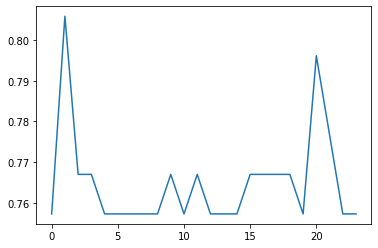

In [17]:
import matplotlib.pyplot as plt
plt.plot(lda_scores)

In [18]:
np.mean(lda_scores)

0.7649676375404532

In [19]:
lda_scores[1], lda_scores[20]

(0.8058252427184466, 0.7961165048543689)

In [20]:
y_labels = np.concatenate([y_train, y_test])
filename_output_csv = os.path.join("/content/drive/My Drive/IIITH/GCN_KEGG/KIRC_Stage_TSNE_PCA_Plots","labels.csv")
np.savetxt(filename_output_csv,y_labels)

In [25]:
features_used

['hsa04010 .csv',
 'hsa04015 .csv',
 'hsa04068 .csv',
 'hsa04071 .csv',
 'hsa04150 .csv',
 'hsa04152 .csv',
 'hsa04211 .csv',
 'hsa04270 .csv',
 'hsa04658 .csv',
 'hsa04660 .csv',
 'hsa04664 .csv',
 'hsa04714 .csv',
 'hsa04722 .csv',
 'hsa04724 .csv',
 'hsa04728 .csv',
 'hsa04911 .csv',
 'hsa04912 .csv',
 'hsa04921 .csv',
 'hsa04928 .csv',
 'hsa04929 .csv',
 'hsa04970 .csv',
 'hsa04972 .csv',
 'hsa05200 .csv',
 'hsa05235 .csv']

In [22]:
new_gene_set = set()

for gene in features_used[1]:
  new_gene_set.add(gene)
for gene in features_used[20]:
  new_gene_set.add(gene)

In [23]:
len(new_gene_set)

13

In [24]:
X_train = data_train[new_gene_set]
X_test = data_test[new_gene_set]
assert X_test.shape[1]!=0
# X['y'] = y
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X = np.concatenate([X_train, X_test])
sc = StandardScaler()
X = sc.fit_transform(X)
X_train = X[0:len(y_train)]
X_test = X[len(y_train):]

# Initializing Support Vector classifier
clf1 = ExtraTreesClassifier(max_depth=25, random_state=0, n_estimators=2500)
clf2 = RandomForestClassifier(n_estimators = 2500, criterion = "gini", max_depth = 5,
                                max_features = "auto", min_samples_leaf = 0.005,
                                min_samples_split = 0.005, n_jobs = -1, random_state = 0) 
clf3 = GaussianNB()


eclf3 = VotingClassifier(estimators=[
      ('lr', clf1), ('rf', clf2), ('gb', clf3)],
      voting='soft', weights=[2,3,1.5],
      flatten_transform=True)
eclf3 = eclf3.fit(X_train, y_train)


print(eclf3.score(X_test, y_test))

KeyError: ignored

In [ ]:
len(y_train)